# LSTM 써보기    
이것은 모두의연구소 AIFFEL 부산2기 아이펠톤 팀 레드존의 이창현이 센서 데이터를 LSTM으로 학습시켜 보려고 하는 노트북입니다.  
일단 라벨링 방식에 따라 두 데이터레이블을 병합할 필요가 있습니다. 근데 하나로 일단 돌려도 괜찮습니다.  
LSTM은 시퀀스에 대한 것으로, 여기서는 시계열 데이터를 쓰고 있으므로 그걸 특정 길이로 잘라 쓰도록 합니다. 그렇다면 결측치는 어떻게 처리할까요? 일단 linear하게 interpolation을 하도록 합니다.  

# 업데이트 로그
2022-11-04 16:20 class Lin_Interpolate 디버깅중...

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
ds = pd.read_csv('data/17-19실측(예찰선)labeled.csv', encoding='euc-kr')

In [4]:
ds

,Unnamed: 0,지점,일시,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,0,추자도,2017-01-01 1:00,4.2,306.0,11.0,15.8,0.0,0
1,1,추자도,2017-01-01 2:00,2.6,315.0,10.8,15.7,0.0,0
2,2,추자도,2017-01-01 3:00,2.5,307.0,10.8,15.6,0.0,0
3,3,추자도,2017-01-01 4:00,1.5,331.0,11.0,15.6,0.0,0
4,4,추자도,2017-01-01 5:00,4.2,331.0,10.8,15.6,0.0,0
...,...,...,...,...,...,...,...,...,...
123974,123974,통영,2019-12-30 20:00,10.7,306.0,12.2,13.9,0.0,0
123975,123975,통영,2019-12-30 21:00,11.3,298.0,11.3,13.8,0.0,0
123976,123976,통영,2019-12-30 22:00,11.9,291.0,10.3,13.6,0.0,0
123977,123977,통영,2019-12-30 23:00,14.9,296.0,8.9,13.5,0.0,0


# 1. 전처리

## 결측치 missing values
일단 linear interpolation을 하도록 합니다. 메모리가 크지 않기 때문에 데이터셋을 포함하는 그 어떤 클래스를 만들어서 쓰겠습니다.  
그 전에, 연속적으로 빠진 일시를 파악합니다.

In [146]:
ds0=ds.loc[ds['지점']=='추자도']
ds0

,Unnamed: 0,지점,일시,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,0,추자도,2017-01-01 1:00,4.2,306.0,11.0,15.8,0.0,0
1,1,추자도,2017-01-01 2:00,2.6,315.0,10.8,15.7,0.0,0
2,2,추자도,2017-01-01 3:00,2.5,307.0,10.8,15.6,0.0,0
3,3,추자도,2017-01-01 4:00,1.5,331.0,11.0,15.6,0.0,0
4,4,추자도,2017-01-01 5:00,4.2,331.0,10.8,15.6,0.0,0
...,...,...,...,...,...,...,...,...,...
24390,24390,추자도,2019-12-30 20:00,12.5,357.0,7.8,15.8,0.0,0
24391,24391,추자도,2019-12-30 21:00,12.5,358.0,7.9,16.0,0.0,0
24392,24392,추자도,2019-12-30 22:00,13.4,352.0,6.8,15.5,0.0,0
24393,24393,추자도,2019-12-30 23:00,14.0,357.0,6.6,15.3,0.0,0


In [147]:
#handle time with pandas
pd.to_datetime('2019-12-30 21:00') + pd.Timedelta(1, 'h')

Timestamp('2019-12-30 22:00:00')

In [148]:
print(ds0['일시'].astype('datetime64[s]')[0])

2017-01-01 01:00:00


In [151]:
class Lin_Interpolate:
    """Linear interpolate nan datetimes
    """
    def __init__(self, datetimes:pd.Series):
        self.datetimes=datetimes.astype('datetime64[s]').reset_index()
        self.time_start=datetimes.values[0]
        self.time_end=datetimes.values[-1]
        self.len_data=datetimes.size
    
    def check_sorted(self):
        if (self.datetimes.sort_values(ascending=True) == self.datetimes).all():
            return True
        else:
            return False
    
    def missing_hours(self, t0, t1, datetime_column='일시'):
        t=pd.Timestamp(t0, unit='h')
        missing_hours_list=[]
        missing_hours_df=pd.DataFrame()
        missing_hours_number=0
        
        for idx, dt in self.datetimes.items():
            if t==pd.Timestamp(dt, unit='h'):
                t+=pd.Timedelta(1, 'h')
            else:
                missing_hours_list.append(t)
                t+=pd.Timedelta(1, 'h')
                missing_hours_number+=1
        print('total {} missing hours found'.format(missing_hours_number))
        missing_hours_df[datetime_column]=pd.Series(missing_hours_list).astype('datetime64[s]')
        return missing_hours_df
    
    def fill_hours(self, target_df:pd.DataFrame, datetime_column='일시'):
        return pd.concat([target_df, self.missing_hours(self.time_start, self.time_end)])

In [152]:
lin_interpolate=Lin_Interpolate(ds0['일시'].astype('datetime64[s]'))
lin_interpolate.check_sorted()

TypeError: sort_values() missing 1 required positional argument: 'by'

In [144]:
print(len(ds0))
ds0=lin_interpolate.fill_hours(ds0)
print(len(ds0))

24395
total 24300 missing hours found
48695


# 디버깅중....
약 3년은 $365 \times 24 \times 3=26280$시간이나 조건식이 안맞게 돌아서 그것의 거의 두 배로 행이 늘어났다!

In [124]:
len(ds0['일시'].values)

48695

In [128]:
ds0['일시'].values

array(['2017-01-01 1:00', '2017-01-01 2:00', '2017-01-01 3:00', ...,
       Timestamp('2019-10-14 09:00:00'), Timestamp('2019-10-14 10:00:00'),
       Timestamp('2019-10-14 11:00:00')], dtype=object)

In [ ]:
ds0['일시']=ds0['일시'].to_datetime()

In [127]:
ds0.sort_values(by='일시', ascending=True, inplace=True)

TypeError: '<' not supported between instances of 'Timestamp' and 'str'


## 시퀀스로 전환
얼마의 길이로 자를 것인가 하는게 중요한 hyper-parameter가 될 수도 있겠습니다. 1시간이 1timestep입니다.  
- 한 시퀀스의 field: 72
- window size: 1
- stride 6
- sequence length $\frac{72}{6}=12$  
1번째 시퀀스는 timestep=, 2번째 시퀀스는 timtestep=7에서 시작하도록 합니다. 그렇게 하면 시퀀스의 배치가 이렇게 됩니다.
|timestep|0|1|2|3|4|5|6|7|8|9|1|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|-|
|seq\[0\]|1||||||2||||||3||||||4||||||5|
|seq\[1\]||||||||1||||||2||||||3||||||
|seq\[2\]|||||||||||||||1||||||2|||||

또한, 전체 시퀀스가 시작되거나 끝나는 부분이 아닌 곳에서는 하나의 데이터 포인트가 두 개의 시퀀스에 포함되게 됩니다.

## 모델의 입력과 출력
입력은 일단 5개 지점의 5개 데이터를 통합, 인코더의 embedding size가 $5\times5=25$인 sequence-to-sequence 모델로 작동합니다. 
디코더에서는 입력과 같은 길이를 가지고 0이나 1로 채워지는 시퀀스를 출력합니다. (디코더의 임베딩 사이즈는 1, Boolean이 됩니다.)

In [13]:
#print first row of the table above
print('|'.join(list(map(str, list(range(25))))))

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23


In [19]:
seq_field=72
window=1
stride=6
seq_length=seq_field//stride
len_ds=len(ds)
seq_gen_step=7

seqs_idx=[]

start_idx=0
while start_idx<=len_ds-seq_field:
    seqs_idx.append(list(range(start_idx, start_idx + seq_field, stride)))
    start_idx+=seq_gen_step

In [17]:
list(range(0,seq_field,seq_gen_step))

NameError: name 'seq_gen_step' is not defined

In [20]:
seqs_idx

[[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66],
 [7, 13, 19, 25, 31, 37, 43, 49, 55, 61, 67, 73],
 [14, 20, 26, 32, 38, 44, 50, 56, 62, 68, 74, 80],
 [21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87],
 [28, 34, 40, 46, 52, 58, 64, 70, 76, 82, 88, 94],
 [35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95, 101],
 [42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108],
 [49, 55, 61, 67, 73, 79, 85, 91, 97, 103, 109, 115],
 [56, 62, 68, 74, 80, 86, 92, 98, 104, 110, 116, 122],
 [63, 69, 75, 81, 87, 93, 99, 105, 111, 117, 123, 129],
 [70, 76, 82, 88, 94, 100, 106, 112, 118, 124, 130, 136],
 [77, 83, 89, 95, 101, 107, 113, 119, 125, 131, 137, 143],
 [84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150],
 [91, 97, 103, 109, 115, 121, 127, 133, 139, 145, 151, 157],
 [98, 104, 110, 116, 122, 128, 134, 140, 146, 152, 158, 164],
 [105, 111, 117, 123, 129, 135, 141, 147, 153, 159, 165, 171],
 [112, 118, 124, 130, 136, 142, 148, 154, 160, 166, 172, 178],
 [119, 125, 131, 137, 143, 149, 155, 161, 167, 173, 

In [21]:
len(seqs_idx)

17702

생성된 seqs_idx를 이미지로 바꿔서 한번 살펴봅니다.

In [51]:
seqs_idx[50],len(seqs_idx[50])

([350, 356, 362, 368, 374, 380, 386, 392, 398, 404, 410, 416], 12)

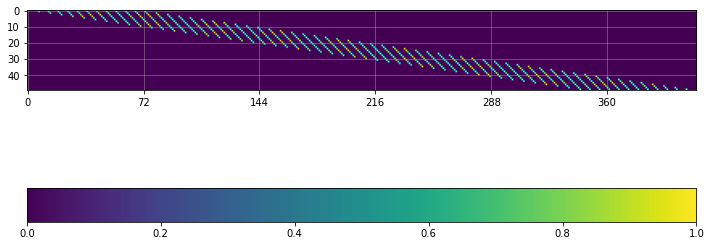

In [70]:
img_size_x = 416
img_size_y = 50
seq_length_squeeze_ratio = 1

img = np.zeros([img_size_y, img_size_x])

for yidx, seq in enumerate(seqs_idx[:img_size_y]):
    #for i in range(seq[0]//seq_length_squeeze_ratio,seq[-1]//seq_length_squeeze_ratio + 1):
    for i in seq:
        if i<img_size_x:
            img[yidx, i]=1.0

plt.figure(figsize=(12,12))
plt.xticks(ticks=list(range(0,img_size_x,seq_field)))
plt.yticks(ticks=list(range(0,img_size_y,10)))

plt.grid(alpha=0.5)
plt.imshow(img)
plt.colorbar(location='bottom')
plt.show()

figure는 50행(수직축)까지 시퀀스별 time-index(수평축)를 점으로 표시합니다.

In [28]:
np.zeros([3,3])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])